In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

import sklearn.metrics

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from detection import rnn_detection as rnn_det
from detection import bls_detection as bls_det
from simulations import lightcurve_simulation as lcsim
import visualize as vis

from dataloading import loading as dl

from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
import matplotlib

from wotan import flatten

In [3]:
# fnames = [fnm for fnm in os.listdir("data/eval/sim/singleplanet") if not fnm.startswith(".")]

# window_lengths = [0.25, 0.5, 1.0]  # days

# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         bls_detections = {}
#         batch = dl.load_data("data/eval/sim/singleplanet/"+fname)
#         if batch is None:
#             continue
#         time = np.arange(len(batch["flux"][0]))*utils.min2day(2)
#         for i in range(len(batch["flux"])):
#             sampleid = int(batch["sampleid"][i])
#             bls_detections[sampleid] = {}
#             for wl in window_lengths:
#                 flat = flatten(time, batch["flux"][i], method="median", window_length=wl)
#                 detected = bls_det.algorithm(time, flat, num_iters=3)
#                 bls_detections[sampleid][wl] = detected
#         with open("results/bls_singles/"+fname, "wb") as f:
#             pickle.dump(bls_detections, f)
            
#     except:
#         pbar.close()
#         raise

In [4]:
# detections = {}
# for fnm in [fnm for fnm in os.listdir("results/bls_singles") if not fname.startswith(".")]:
#     with open("results/bls_singles/"+fnm, "rb") as f:
#         bls_det_batch = pickle.load(f)
#         detections = {**detections, **bls_det_batch}
# with open("results/bls_single_detections.pkl", "wb") as f:
#     pickle.dump(detections, f)

In [5]:
# rnn_ = torch.load("models/bigru1_w4sqrt_sim.pt")

In [6]:
# mean, std = -0.10192371859533564, 2.6337997430623323  # obtained from training set
# fnames = [fnm for fnm in os.listdir("data/eval/sim/monotransit") if not fnm.startswith(".")]

# rnn_.to("cpu")


# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         rnn_detections = {}
#         batch = dl.load_data("data/eval/sim/singleplanet/"+fname)
#         if batch is None:
#             continue
#         sigma = np.array([batch["meta"][i]["sigma"] for i in batch["sampleid"]])
#         flux_ = ((batch["flux"]-1) / sigma[:,None] - mean) / std
  
#         flux_in = flux_.reshape(-1,flux_.shape[-1])
#         pts_ = np.zeros_like(flux_in)

#         step = 50
#         for i in range(step, len(flux_in)+1, step):
#             pts_[i-step:i] = rnn_det.get_pts(rnn_, flux_in[i-step:i], additional=False)
#             rnn_.to("cpu")

#         for i, sampleid in enumerate(batch["sampleid"]):
#             detected1 = rnn_det.algorithm1(pts_[i].copy(), num_iters=3, min_transits=3, p_min=2, p_max=None, step_mult=2, 
#                smooth=True, peak_frac=2, show_steps=False)
            
#             detected2 = rnn_det.algorithm2(pts_[i], None, num_iters=3, smooth=True, p_min=2)

#             rnn_detections[sampleid] = {"rnn1":detected1,
#                                         "rnn2":detected2}
#         with open("results/rnn_singles/"+fname, "wb") as f:
#             pickle.dump(rnn_detections, f)                       

#     except:
#         pbar.close()
#         raise

In [7]:
# detections = {}
# for fnm in [fnm for fnm in os.listdir("results/rnn_singles") if not fname.startswith(".")]:
#     with open("results/rnn_singles/"+fnm, "rb") as f:
#         rnn_det_batch = pickle.load(f)
#         detections = {**detections, **rnn_det_batch}
# with open("results/rnn_single_detections.pkl", "wb") as f:
#     pickle.dump(detections, f)

## Results

In [8]:
def correct_detection(params, detection, dur_factor=1, per_frac=0.01):
    # assumes sample (params) contains single planet 
    if params["planets"] == {}:
        print("sample contains no planets")
        raise Exception
    t0_true = params["planets"][0]["pl_t0"]
    dur_true = params["planets"][0]["pl_duration"]
    per_true = params["planets"][0]["pl_period"]
    t0_correct = (detection["t0"] > (t0_true - 0.5*dur_factor*dur_true)) and \
                 (detection["t0"] < (t0_true + 0.5*dur_factor*dur_true))
    per_correct = (1-per_frac)*per_true < detection["period"] and detection["period"] < (1+per_frac)*per_true
    correct = (t0_correct and per_correct)
    return correct

def get_data_params(load_dir="data/eval/sim/singleplanet"):
    meta = {}
    fnames = [fnm for fnm in os.listdir(load_dir) if not fnm.startswith(".")]
    for fname in fnames:
        batch = dl.load_data(load_dir + "/"+fname)
        if batch is None:
            continue
        meta = {**meta, **batch["meta"]}
    return meta

def get_results(load_pkl, best_only=False):
    with open(load_pkl, "rb") as f:
        detections = pickle.load(f)
    if best_only:
        for i in detections:
            for mname in detections[i]:
                if len(list(detections[i][mname].keys())):
                    mx = np.max(list(detections[i][mname].keys()))
                    detections[i][mname] = {mx:detections[i][mname][mx]}
    return detections


def evaluate_thresholds(detections, thresholds):
    snames = ["tp", "fp", "fn", "tn"]
    results = {mname:{sname:[] for sname in snames} for mname in detections[0]}
    pbar = tqdm(thresholds)
    for thr in pbar:  
        try:
            for mname in detections[0]:
                dic = results[mname]
                tp = fp = tn = fn = 0
                for i in meta:
                    contains_planet = len(meta[i]["planets"]) > 0
                    found_planet = False
                    for score, det in detections[i][mname].items():
                        if score >= thr:
                            if contains_planet and correct_detection(meta[i], det):
                                tp += 1
                                found_planet = True 
                            else:  # no planets in lc or false detection
                                fp += 1
                    if contains_planet and not found_planet:
                        fn += 1
                    # true negative is always inf
                results[mname]["tp"].append(tp), results[mname]["fp"].append(fp) 
                results[mname]["tn"].append(tn), results[mname]["fn"].append(fn) 
        except:
            pbar.close()
            raise
    for mname in detections[0]:
        for sname in snames:
            results[mname][sname] = np.array(results[mname][sname])
    return results

def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    # recall
    return dic["tp"] / (dic["tp"] + dic["fn"])

def get_recall(dic):
    return get_tpr(dic)

def get_precision(dic):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prec = dic["tp"] / (dic["tp"] + dic["fp"])
    prec[np.isnan(prec)] = 1
    return prec

def get_threshold(threshold_results, thresholds, precision_lvl=0.9, min_recall=0.1):
    precision = get_precision(threshold_results)
    recall = get_recall(threshold_results)
    r_msk = recall > min_recall
    argmin = np.argmin(np.abs(precision[r_msk]-precision_lvl))
    thr = thresholds[argmin]
    return thr, precision[argmin], recall[argmin]

In [9]:
meta = get_data_params()
bls_detections = get_results("results/bls_single_detections.pkl")
rnn_detections = get_results("results/rnn_single_detections.pkl")
rnn_sde_detections = get_results("results/rnn_sde_single_detections.pkl")

In [10]:
scores = {mname:[] for mname in [*bls_detections[0], *rnn_detections[0], *rnn_sde_detections[0]]}
for i in meta:
    for mname, dic in {**bls_detections[i], **rnn_detections[i], **rnn_sde_detections[i]}.items():
        for score in dic:
            scores[mname].append(score)
for mname in scores:
    print(f"{mname}:  min = {round(min(scores[mname]),2)} | max = {round(max(scores[mname]),2)} | " +
          f"avg = {round(np.mean(scores[mname]),2)}")

bls_6h:  min = 2.93 | max = 17.76 | avg = 5.54
bls_12h:  min = 2.3 | max = 17.28 | avg = 5.17
bls_24h:  min = 0.89 | max = 38.66 | avg = 4.58
rnn_alg1:  min = 0.23 | max = 3.74 | avg = 0.86
rnn_alg2:  min = 0.2 | max = 3.74 | avg = 0.9
rnnc_alg1:  min = 0.16 | max = 3.74 | avg = 0.71
rnnc_alg2:  min = 0.19 | max = 3.74 | avg = 0.81
rnnc_conf_alg1:  min = 0.15 | max = 3.73 | avg = 0.6
rnnc_conf_alg2:  min = 0.18 | max = 3.73 | avg = 0.75
rnn_ez_alg1:  min = 0.04 | max = 3.74 | avg = 0.41
rnn_ez_alg2:  min = 0.08 | max = 3.74 | avg = 0.92
rnn_flat_alg1:  min = 0.27 | max = 3.74 | avg = 0.87
rnn_flat_alg2:  min = 0.26 | max = 3.74 | avg = 0.92
rnn_sde_alg1:  min = 1.47 | max = 12.49 | avg = 3.2


In [11]:
bls_thresholds =  np.linspace(0,30,100)
bls_results = evaluate_thresholds(bls_detections, bls_thresholds)

100%|██████████| 100/100 [00:05<00:00, 19.96it/s]


In [12]:
rnn_thresholds = np.linspace(0,4,100)
rnn_results = evaluate_thresholds(rnn_detections, rnn_thresholds)

100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


In [13]:
rnn_sde_thresholds = np.linspace(0,15,100)
rnn_sde_results = evaluate_thresholds(rnn_sde_detections, rnn_sde_thresholds)

100%|██████████| 100/100 [00:01<00:00, 92.03it/s]


In [14]:
def get_pr_curve(results, mnames):
    for mname, lbl in mnames.items():
        dic = results[mname]
        rec, prec = get_recall(dic), get_precision(dic)
        auc = sklearn.metrics.auc(rec, prec)
        lbl = lbl + f"  ({round(auc,2)})"
        plt.plot(get_recall(dic), get_precision(dic), label=lbl)
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)  
        plt.xticks(fontsize=13), plt.yticks(fontsize=13)

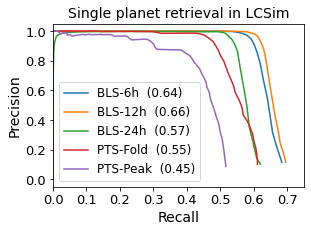

In [15]:
mnames = {"bls_6h":"BLS-6h", 
          "bls_12h":"BLS-12h",
          "bls_24h":"BLS-24h",
          "rnn_alg1":"PTS-Fold",
          "rnn_alg2":"PTS-Peak"}
combined_results = {**bls_results, **rnn_results, **rnn_sde_results}

plt.figure(figsize=(4.5,3))
get_pr_curve(combined_results, mnames)
plt.title("Single planet retrieval in LCSim", fontsize=14)
plt.legend(fontsize=12, loc="lower left"), plt.xlim(0.00,0.75), plt.ylim(-0.05,1.05)
plt.show()

In [16]:
def wilson(bool_array, conf=0.95):
    # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    n = bool_array.size
    z = 1.96 
    if conf != 0.95:
        print("WARNING: using conf=0.95")  
    phat = bool_array.mean()
    mean = 1/(1+z**2/n) * (phat + z**2/(2*n))
    unc = z/(1+z**2/n) * np.sqrt(phat*(1-phat)/n + z**2/(4*n**2))
    return mean, unc

def get_bin_indc(array, n_bins=10, rng=(-1e9,1e9)):
    stepsize = (min(array.max(),rng[1])-max(array.min(),rng[0])+1e-9)/n_bins
    bin_indc = []
    minimum = max(array.min(),rng[0])
    steps = [minimum+stepsize/2+i*stepsize for i in range(n_bins)]
    for bi in range(n_bins):
        low = minimum + bi*stepsize
        high = minimum + (bi+1)*stepsize
        bin_indc.append( np.where((array>=low)*(array<high))[0] )
    return bin_indc, np.array(steps)

def vs_plot(steps, stats, n_samples, xlbl="", legend=False, labels=None, offset=0.1, fill=True, rot=0,
            min_acc=0.5, max_acc=1.02):
    plt.figure(figsize=(5,3),facecolor="w")
    offs = 0
    for i,stat in enumerate(stats):
        if fill:
            p = plt.plot(steps, stat["mean"], label=labels[i])
            plt.fill_between(steps, np.array(stat["mean"])-np.array(stat["unc"]), 
                             np.array(stat["mean"])+np.array(stat["unc"]), alpha=.3, color=p[0].get_color())
        else:
            plt.errorbar(steps+offs, stat["mean"], yerr=stat["unc"], capsize=2, label=labels[i])
        if offset:
            offs += offset*(steps[1]-steps[0])
    if rot:
        plt.xticks(fontsize=13, rotation=rot, ha='right')
    else:
        plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel("Fraction correct", fontsize=14)
    plt.xlabel(xlbl, fontsize=14)
    plt.xlim(steps[0]-0.5*(steps[1]-steps[0]),steps[-1]+0.5*(steps[1]-steps[0]))
    plt.ylim(min_acc,max_acc)
    if legend:
        plt.legend(loc="center right", framealpha=1, fontsize=12, facecolor="w", ncol=1)
    ax = plt.twinx()
    plt.bar(steps, n_samples, alpha=0.2, color="gray", width=(steps[1]-steps[0]), label="Samples", zorder=0)
    plt.ylabel("#samples", fontsize=14)
    plt.yticks(fontsize=13)
    if legend:
        plt.legend(loc="lower left", framealpha=1, fontsize=12)
    
def plot_1d(model_correct, array, labels, n_bins=10, xlbl="", legend=True, offset=0.01, 
            fill=True, show=True, rot=0, min_acc=0.5, rng=(None,None), max_acc=1.02):
    
    rng = (-1e9, rng[1]) if rng[0] is None else rng
    rng = (rng[0], 1e9) if rng[1] is None else rng
    
    bin_indc, steps = get_bin_indc(array, n_bins=n_bins, rng=rng)
    n_samples = np.array([len(indc) for indc in bin_indc])
    
    model_confs = {model:{"mean":[],"unc":[]} for model in labels}
    for indc in bin_indc:
        if len(indc)==0:
            for model in model_confs:
                model_confs[model]["mean"].append(np.nan)
                model_confs[model]["unc"].append(np.nan)
        else:
            for i, model in enumerate(model_confs):
                mean, unc = wilson(model_correct[i][indc])
                model_confs[model]["mean"].append(mean)
                model_confs[model]["unc"].append(unc)
    vs_plot(steps, list(model_confs.values()), n_samples, xlbl, legend, labels, offset=offset, 
            fill=fill, rot=rot, min_acc=min_acc, max_acc=max_acc)
    if show:
        plt.show()

In [17]:
def get_scores(mname, detect_dic, results_dic, thresholds, precision_lvl=0.9, 
               min_recall=0.1, return_sampleids=False):
    thresh = get_threshold(results_dic[mname], thresholds, precision_lvl=precision_lvl,
                          min_recall=min_recall)[0]
    correct_detections = [] 
    sampleids = []
    for i in meta:
        if len(meta[i]["planets"]) > 0:
            sampleids.append(i)
            correct = False
            for score, det in detect_dic[i][mname].items():
                if score > thresh and correct_detection(meta[i], det):
                    correct = True
                    break
            correct_detections.append(correct)
    if return_sampleids:
        return np.array(correct_detections), np.array(sampleids)
    return np.array(correct_detections)


def get_data_params(meta, pname, fn=lambda a:a, pl_param=True):
    if pl_param:
        lst = [fn(meta[i]["planets"][0][pname]) for i in meta if len(meta[i]["planets"])]
    else:
        lst = [fn(meta[i][pname]) for i in meta if len(meta[i]["planets"])]
    return np.array(lst)

In [18]:
# at threshold for for which recall>0.1 and precision closest to 0.9
prec_lvl = 0 # precision_lvl
min_rec = 0.1 # min_recall

rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, 
                                          precision_lvl=prec_lvl, min_recall=min_rec, return_sampleids=1)
bls_scores = get_scores("bls_12h", bls_detections, bls_results, bls_thresholds,
                       precision_lvl=prec_lvl, min_recall=min_rec)

In [19]:
# at threshold for for which recall>0.1 and precision closest to 0.9


rnn_thresh, rnn_prec, rnn_rec = get_threshold(rnn_results["rnn_alg1"], rnn_thresholds, 
                                              precision_lvl=prec_lvl, min_recall=min_rec)
bls_thresh, bls_prec, bls_rec = get_threshold(bls_results["bls_12h"], bls_thresholds,
                                             precision_lvl=prec_lvl, min_recall=min_rec)

print(f"Total lcs: {len(rnn_detections)}")
print(f"1 pl:      {len(rnn_scores)}\n")
print(f"PTS-Fold:  {sum(rnn_scores)} ({round(rnn_scores.mean(),2)})  "+
      f"|  prec: {round(rnn_prec, 2)},  rec: {round(rnn_rec,2)},  threshold: {round(rnn_thresh,2)}") 
print(f"BLS-12h:   {sum(bls_scores)} ({round(bls_scores.mean(),2)})  "+
      f"|  prec: {round(bls_prec, 2)},  rec: {round(bls_rec,2)},  threshold: {round(bls_thresh,2)}")

Total lcs: 5000
1 pl:      2500

PTS-Fold:  1527 (0.61)  |  prec: 0.1,  rec: 0.61,  threshold: 0.0
BLS-12h:   1737 (0.69)  |  prec: 0.12,  rec: 0.7,  threshold: 0.0


In [20]:
depth = get_data_params(meta, "pl_ror", lambda a:a**2)
sigma = get_data_params(meta, "sigma", pl_param=0)
duration = get_data_params(meta, "pl_duration", lambda a:a*24)
period = get_data_params(meta, "pl_period")
n_transits = get_data_params(meta, "pl_transits")
rot_sigma = get_data_params(meta, "rot_sigma", pl_param=0, fn=lambda a:a*1000)
rot_period = get_data_params(meta, "rot_period", pl_param=0)
gran_sigma = get_data_params(meta, "gran_sigma", pl_param=0, fn=lambda a:a*1000)
gran_period = get_data_params(meta, "gran_period", pl_param=0, fn=lambda a:a*24)

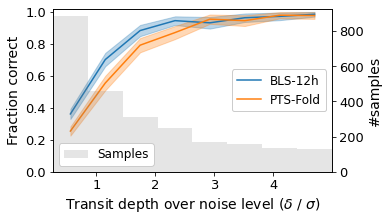

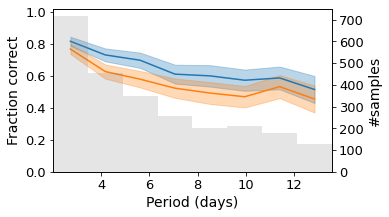

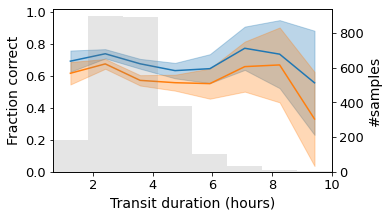

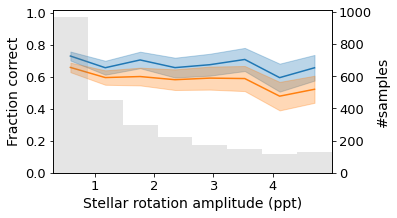

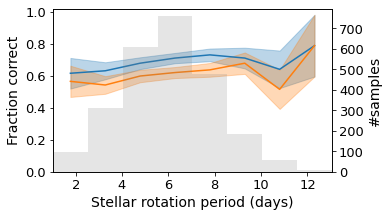

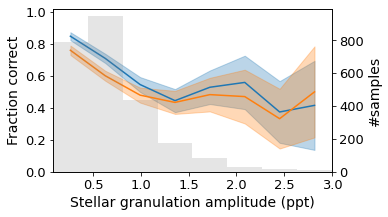

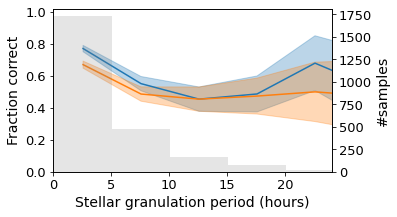

In [35]:
# a,b=duration,gran_period
# a,b=depth*1000,gran_sigma
# plot_1d([bls_scores, rnn_scores],
#         1 - np.vstack((a,b)).min(0)/np.vstack((a,b)).max(0), labels=["BLS-12h","PTS-Fold"], xlbl="x", 
#          legend=False, n_bins=4, offset=0.1, fill=True, min_acc=0, rng=(None,0.5), max_acc=None)

plot_1d([bls_scores, rnn_scores],
         depth/sigma, labels=["BLS-12h","PTS-Fold"], xlbl="Transit depth over noise level ($\delta$ / $\sigma$)", 
         legend=True, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,None))

plot_1d([bls_scores, rnn_scores],
         period, labels=["BLS-12h","PTS-Fold"], xlbl="Period (days)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,None))

plot_1d([bls_scores, rnn_scores],
         duration, labels=["BLS-12h","PTS-Fold"], xlbl="Transit duration (hours)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,10))

plot_1d([bls_scores, rnn_scores],
         rot_sigma, labels=["BLS-12h","PTS-Fold"], xlbl="Stellar rotation amplitude (ppt)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,None))

plot_1d([bls_scores, rnn_scores],
         rot_period, labels=["BLS-12h","PTS-Fold"], xlbl="Stellar rotation period (days)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, show=0, rng=(None,None))

plot_1d([bls_scores, rnn_scores],
         gran_sigma, labels=["BLS-12h","PTS-Fold"], xlbl="Stellar granulation amplitude (ppt)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,0.003*1000))

plot_1d([bls_scores, rnn_scores],
         gran_period, labels=["BLS-12h","PTS-Fold"], xlbl="Stellar granulation period (hours)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, show=0, rng=(None,40))
plt.xlim(0,24)
plt.show()

In [22]:
def plot_2d(model_correct, array_1, array_2, n_bins_1=10, n_bins_2=10, label_1="", label_2="", min_size=5, 
            show=True, title="", rng1=(-1e9,1e9), rng2=(-1e9,1e9)):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "orange","yellow","limegreen","green"])
    acc_match = np.linspace(0,1,1000)
    colors = cmap(acc_match)

    bin_indc1, steps1 = get_bin_indc(array_1, n_bins=n_bins_1, rng=rng1)
    bin_indc2, steps2 = get_bin_indc(array_2, n_bins=n_bins_2, rng=rng2)
    stepsize1, stepsize2 = steps1[1]-steps1[0], steps2[1]-steps2[0]

    for i, step1 in enumerate(steps1):
        for j, step2 in enumerate(steps2):
            min1, max1 = step1-0.5*stepsize1, step1+0.5*stepsize1
            min2, max2 = step2-0.5*stepsize2, step2+0.5*stepsize2
            indc = np.array(list(set(bin_indc1[i]).intersection(bin_indc2[j])))
            if len(indc)<min_size:
                color = "white"
            else:
                bin_acc = (model_correct[indc].mean()-0.3)/0.5
                color = colors[np.abs(acc_match-bin_acc).argmin()]
            plt.fill_between([min1, max1], min2, max2, color=color)

    plt.title(title, fontsize=14)
    plt.xlim(steps1[0]-0.5*stepsize1,steps1[-1]+0.5*stepsize1)
    plt.ylim(steps2[0]-0.5*stepsize2,steps2[-1]+0.5*stepsize2)
    cm = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap))
#     cm.ax.set_yticklabels(["$\leq$\n0.5\n","0.6","0.7","0.8","0.9","1.0"])
    cm.ax.set_yticklabels(["$\leq$\n0.3\n","0.4","0.5","0.6","0.7","0.8\n$\geq$"])
    cm.ax.tick_params(labelsize=13)
    plt.xlabel(label_1, fontsize=14)
    plt.ylabel(label_2, fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    cm.set_label("Fraction correct", fontsize=14)
    if show:
        plt.show()
        
def pair_2d(stats, array_1, array_2, titles, label_1, label_2, n_bins_1=10, n_bins_2=10, 
            rng1=(None,None), rng2=(None,None)):
    rng1 = (-1e9, rng1[1]) if rng1[0] is None else rng1
    rng1 = (rng1[0], 1e9) if rng1[1] is None else rng1
    rng2 = (-1e9, rng2[1]) if rng2[0] is None else rng2
    rng2 = (rng2[0], 1e9) if rng2[1] is None else rng2 
        
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    plot_2d(stats[0], array_1, array_2, title=titles[0],
        label_1=label_1, label_2=label_2, n_bins_1=n_bins_1, n_bins_2=n_bins_2, min_size=5, show=0,
           rng1=rng1, rng2=rng2)
    plt.subplot(1,2,2)
    plot_2d(stats[1], array_1, array_2, title=titles[1],
        label_1=label_1, label_2=label_2, n_bins_1=n_bins_1, n_bins_2=n_bins_2, min_size=5, show=0,
           rng1=rng1, rng2=rng2)
    plt.tight_layout()
    plt.show()

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


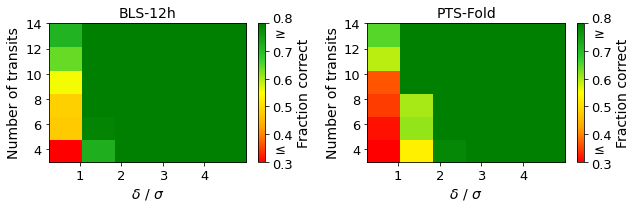

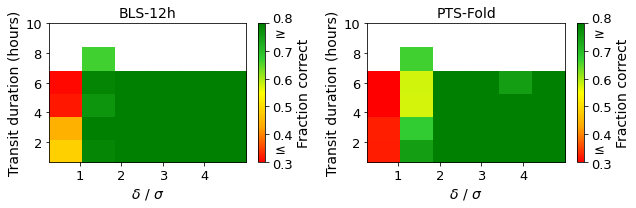

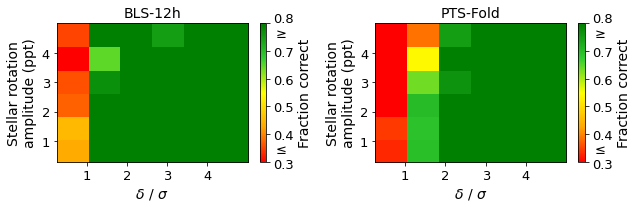

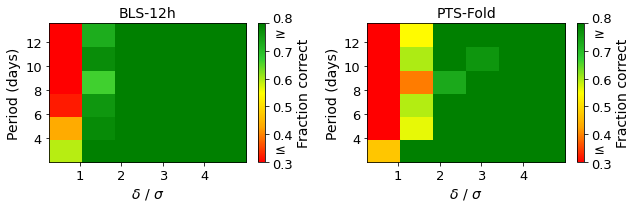

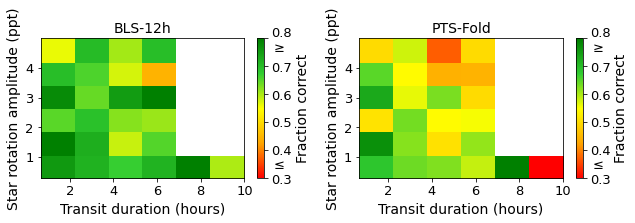

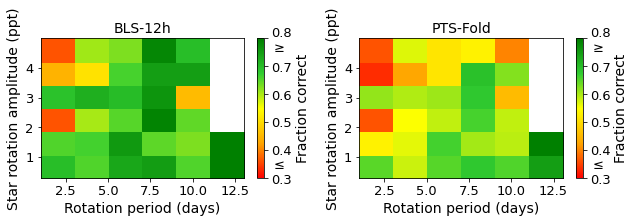

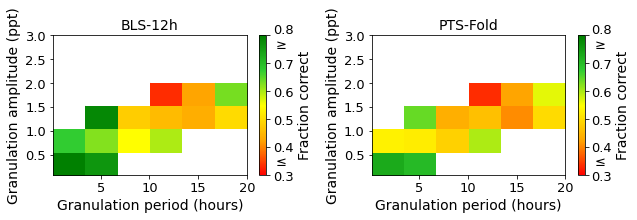

In [23]:
array_1, label_1 = depth/sigma, "$\delta$ / $\sigma$"
array_2, label_2 = n_transits, "Number of transits"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,None), rng2=(None,None))

array_1, label_1 = depth/sigma, "$\delta$ / $\sigma$"
array_2, label_2 = duration, "Transit duration (hours)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(-1e9,1e9), rng2=(None,10))

array_1, label_1 = depth/sigma, "$\delta$ / $\sigma$"
array_2, label_2 = rot_sigma, "Stellar rotation\namplitude (ppt)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,None), rng2=(None,None))

array_1, label_1 = depth/sigma, "$\delta$ / $\sigma$"
array_2, label_2 = period, "Period (days)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,None), rng2=(None,None))

array_1, label_1 = duration, "Transit duration (hours)"
array_2, label_2 = rot_sigma, "Star rotation amplitude (ppt)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,10), rng2=(None,None))

array_1, label_1 = rot_period, "Rotation period (days)"
array_2, label_2 = rot_sigma, "Star rotation amplitude (ppt)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,None), rng2=(None,None))

array_1, label_1 = gran_period, "Granulation period (hours)"
array_2, label_2 = gran_sigma, "Granulation amplitude (ppt)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,20), rng2=(None,0.003*1000))

In [28]:
def A_vs_B(Ascores, Bscores, sampleids):
    results = {}
    results["AandB"] = sampleids[ (Ascores & Bscores) ]
    results["AnotB"] = sampleids[ (Ascores & (~Bscores)) ]
    results["BnotA"] = sampleids[ ((~Ascores) & Bscores) ]
    results["notBnotA"]= results["notAnotB"] = sampleids[ ~(Ascores | Bscores) ]
    return results

In [31]:
Arnn_Bbls = A_vs_B(rnn_scores, bls_scores, scores_sampleids)
for i in Arnn_Bbls:
    print(i, len(Arnn_Bbls[i]))

AandB 1489
AnotB 38
BnotA 248
notBnotA 725
notAnotB 725


In [32]:
def get_lc(sampleid, datapath="data/eval/sim/singleplanet"):
    for fnm in os.listdir(datapath):
        if not fnm.startswith("."):
            from_, to_ = [int(nm) for nm in fnm.split("-")]
            if sampleid >= from_ and sampleid <= to_:
                id_data = {}
                with open(datapath + "/" + fnm, "rb") as f:
                    batch = pickle.load(f)
                i = np.where(batch["sampleid"]==sampleid)[0][0]
                id_data["flux"] = batch["flux"][i]
                id_data["mask"] = batch["mask"][i]
                id_data["transit"] = batch["transit"][i]
                id_data["sigma"] = batch["sigma"][i]
                id_data["sampleid"] = batch["sampleid"][i]
                id_data["meta"] = batch["meta"][sampleid]
                return id_data

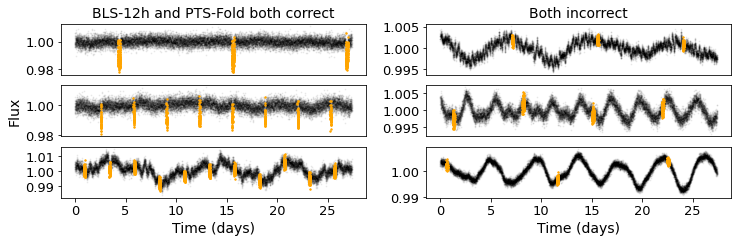

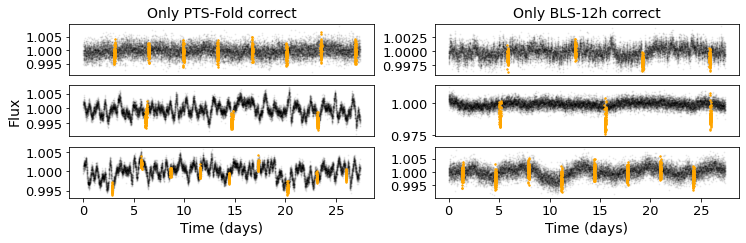

In [33]:
n = 3 
np.random.seed(1)

fns = {"upper left": lambda i: i*2+1,
       "lower left": lambda i: i*2+1+n*2, 
       "upper right": lambda i: i*2+2, 
       "lower right": lambda i: i*2+2+n*2}
snames = ["AandB", "notAnotB", "AnotB", "BnotA"]
titles = ["BLS-12h and PTS-Fold both correct",
          "Both incorrect", "Only PTS-Fold correct",
          "Only BLS-12h correct"]
locs = ["upper left", "upper right", "lower left", "lower right"]

for fg in [(0,2),(2,4)]:
    plt.figure(figsize=(12,1.1*n*2))
    for si, (sname, loc) in enumerate(zip(snames[fg[0]:fg[1]], locs[fg[0]:fg[1]])):   
        s_ids = np.random.choice(Arnn_Bbls[sname], replace=False, size=n)
        for i, s_id in enumerate(s_ids):
            plt.subplot(n*2, 2, fns[loc](i))
            plt.title(titles[fg[0]:fg[1]][si], fontsize=14) if i == 0 else None
            b = get_lc(s_id)
            m = b["mask"]
            plt.ylabel("Flux", fontsize=14) if i==1 and si==0 else None
            time = np.arange(len(b["flux"])) * utils.min2day(2)
            vis.plot(time[~m], b["flux"][~m], a=0.05)
            vis.plot(time[m], b["flux"][m], c="orange", s=2, z=200)
            plt.yticks(fontsize=13)
            plt.xticks([]) if i!=n-1 else plt.xticks(fontsize=13)
            plt.xlabel("Time (days)", fontsize=14)  if i==n-1 else None